In [1]:
#----- IMPORT -----
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, grad
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import time
from random import choices
from scipy import misc
import ot

import seaborn as sns; sns.set(color_codes=True)

from geomloss import SamplesLoss

use_cuda = torch.cuda.is_available()
device    = 'cuda' if use_cuda else 'cpu'

In [2]:
################ Generator model #################
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()
        

class Neural_network(nn.Module):
    """docstring for Neural_network."""
    def __init__(self):
        super(Neural_network, self).__init__()
        self.linear1 = nn.Linear(10, 128)
        self.linear2 = nn.Linear(128,32)
        self.linear3 = nn.Linear(32,2)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return self.linear3(x)

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)


def display_samples(ax, x, color):
    x_ = x.detach().cpu().numpy()
    ax.scatter( x_[:,0], x_[:,1], 25*500 / len(x_), color, edgecolors='none' )


###########################
# Gradient Flow
###########################

class Sqrt0(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input):
        result = input.sqrt()
        result[input < 0] = 0
        ctx.save_for_backward(result)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        result, = ctx.saved_tensors
        grad_input = grad_output / (2*result)
        grad_input[result == 0] = 0
        return grad_input

def sqrt_0(x):
    return Sqrt0.apply(x)


def squared_distances(x, y):
    if x.dim() == 2:
        D_xx = (x*x).sum(-1).unsqueeze(1)  # (N,1)
        D_xy = torch.matmul( x, y.permute(1,0) )  # (N,D) @ (D,M) = (N,M)
        D_yy = (y*y).sum(-1).unsqueeze(0)  # (1,M)
    elif x.dim() == 3:  # Batch computation
        D_xx = (x*x).sum(-1).unsqueeze(2)  # (B,N,1)
        D_xy = torch.matmul( x, y.permute(0,2,1) )  # (B,N,D) @ (B,D,M) = (B,N,M)
        D_yy = (y*y).sum(-1).unsqueeze(1)  # (B,1,M)
    else:
        print("x.shape : ", x.shape)
        raise ValueError("Incorrect number of dimensions")

    return D_xx - 2*D_xy + D_yy


def distances(x, y):
    return sqrt_0( squared_distances(x,y) )


def emd(mb_C, mb_size):
    mb_a, mb_b = ot.unif(mb_size), ot.unif(mb_size)
    return ot.emd(mb_a, mb_b, mb_C.detach().cpu().numpy().copy())


def train_GAN_MB(Y_j, mb_size, K, loss=None, lr=.005, Nsteps = 10001, device=device) :
    """Flows along the gradient of the cost function, using a simple Euler scheme.

    Parameters:
        loss ((x_i,y_j) -> torch float number):
            Real-valued loss function.
        lr (float, default = .005):
            Learning rate
    """

    # Parameters for the gradient descent
    
    display_its = [int(Nsteps/8), int(Nsteps/4), int(Nsteps/2), Nsteps-1] #plot results for wanted iteration
    print(display_its)
    loss_error = []

    # Make sure that we won't modify the reference samples
    y_j = Y_j.clone()
    y_j.to(device)
    nt = y_j.size()[0]

    net = Neural_network()
    net.to(device)
    net.weight_init(mean=0.0, std=0.05)
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(0, 0.9))
    
    t_0 = time.time()
    plt.figure(figsize=(18,6)) ; k = 1
    
    for i in range(Nsteps): # Euler scheme ===============
        optimizer.zero_grad()
        
        for _ in range(K):
            mb_x = torch.randn(mb_size, 10).type(torch.FloatTensor).to(device) #Batch source
            mb_t = np.random.choice(nt, size=mb_size, replace=False) #Batch target
            mb_y = y_j[mb_t]

            f_x = net(mb_x) # G(z)
            if loss is not None:
                Loss = loss(f_x, mb_y) # Compute Sinkhorn divergence
            else:
                C = distances(f_x, mb_y)
                pi = torch.as_tensor(emd(C, mb_size)).to(device)
                Loss = torch.sum(pi * C.double())
            Loss.backward() # Compute gradient
        optimizer.step()

        if i%1000==0:
            print(i)
            with torch.no_grad():
                loss_error.append(Loss.item())

        if i in display_its : # display
            mb_x = torch.randn(nt, 10).type(torch.FloatTensor).to(device)
            f_x = net(mb_x)
            
            ax = plt.subplot(1,4,k)
            plt.set_cmap("hsv")
            sns.kdeplot(f_x.cpu().detach().numpy(), ax=ax, shade=True)
            ax.set_title("MB={}, K={}, t = {:1.2f}".format(mb_size, K, lr*i))
            #plt.gca().set_aspect('equal', adjustable='box')
            plt.xticks([], []); plt.yticks([], [])
            k = k+1
    plt.title("MB batch : t = {:1.2f}, elapsed time: {:.2f}s/it".format(lr*i, (time.time() - t_0)/Nsteps ))
    plt.tight_layout()
    plt.savefig('imgs/mb_GAN_2D.png')
    plt.show()
    
    mb_x = torch.randn(nt, 10).type(torch.FloatTensor).to(device)
    f_x = net(mb_x)
    return loss_error, f_x

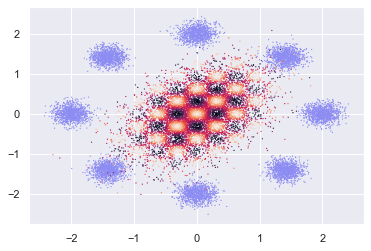

In [3]:
############################
#   DATA
############################

ns = 8000
nt = 8000

mu_s = np.array([0, 0])
cov_s = np.array([[0.2, 0], [0.2, 0.3]])

X_i = ot.datasets.make_2D_samples_gauss(ns, mu_s, cov_s)

Y_j = np.zeros((nt, 2))
pos_x = [2*np.cos(0), 2*np.cos(np.pi/4), 2*np.cos(np.pi/2), 2*np.cos(3*np.pi/4), 2*np.cos(np.pi), 2*np.cos(5*np.pi/4), 2*np.cos(6*np.pi/4), 2*np.cos(7*np.pi/4)]
pos_y = [2*np.sin(0), 2*np.sin(np.pi/4), 2*np.sin(np.pi/2), 2*np.sin(3*np.pi/4), 2*np.sin(np.pi), 2*np.sin(5*np.pi/4), 2*np.sin(6*np.pi/4), 2*np.sin(7*np.pi/4)]

for i in range(8):
    mu_t = np.array([pos_x[i], pos_y[i]])
    cov_t = np.array([[0.02, 0], [0, 0.02]])

    y = ot.datasets.make_2D_samples_gauss(int(nt/8), mu_t, cov_t)
    for k in range(len(y)):
        Y_j[k + (i)*len(y)] = y[k]

X_i = torch.FloatTensor(X_i).to(device)
Y_j = torch.FloatTensor(Y_j).to(device)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
colors = (10*X_i[:,0]).cos() * (10*X_i[:,1]).cos()
colors = colors.detach().cpu().numpy()
display_samples(ax, Y_j, [(.55,.55,.95)])
display_samples(ax, X_i, colors)
plt.show()

[375, 750, 1500, 3000]
0
1000
2000
3000


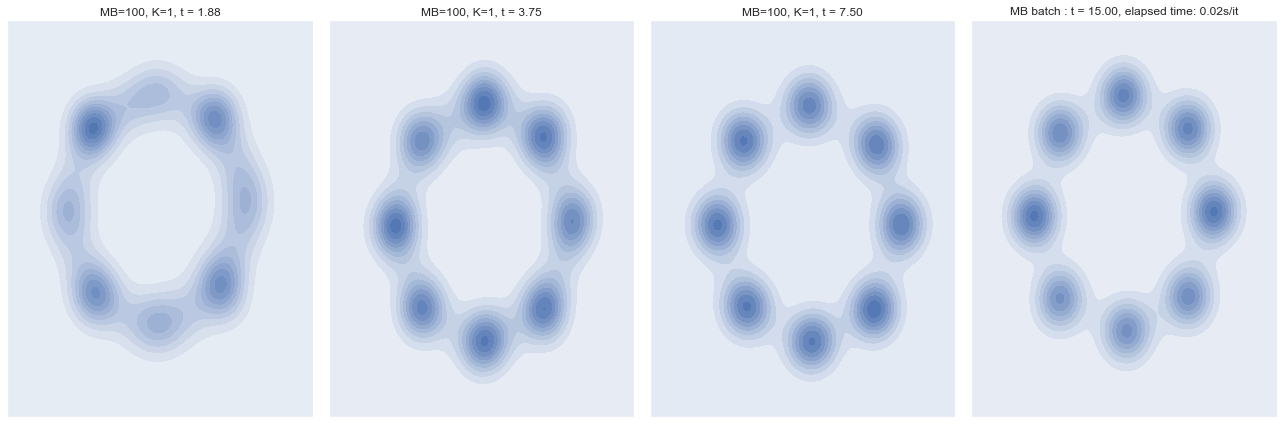

In [6]:
mb_size = 100
K = 1
sinkh_error, f_x_sinkhorn = train_GAN_MB(Y_j, mb_size, K, 
                                         loss=SamplesLoss("sinkhorn", p=1, blur=0.01), 
                                         Nsteps = 3001, device=device) # Primal SD

[3750, 7500, 15000, 30000]
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000


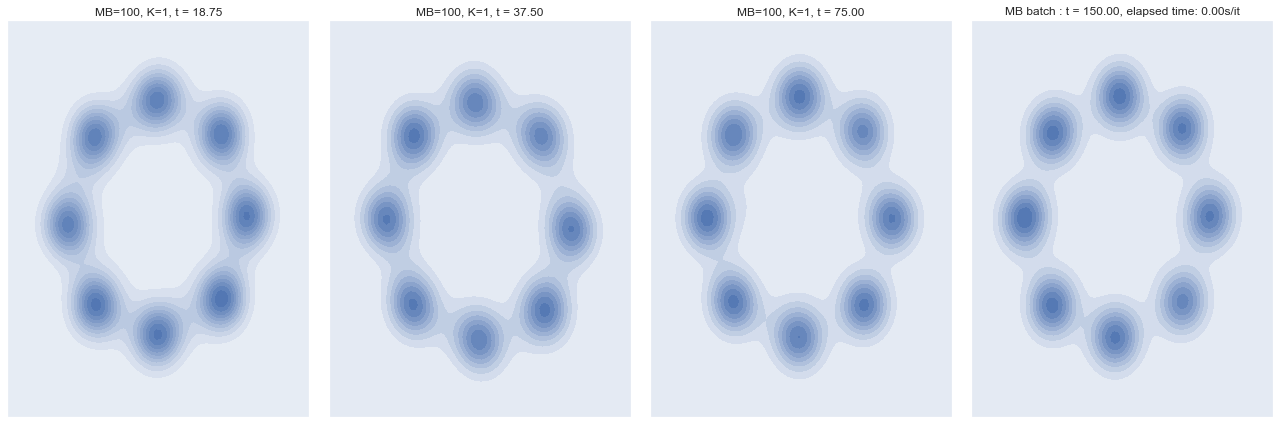

In [7]:
wass_error, f_x_wass = train_GAN_MB(Y_j, mb_size, K, Nsteps = 30001, device=device) # Primal true Wasserstein